In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model

from imblearn.under_sampling import RandomUnderSampler

In [2]:
def my_import():
    
    # Still including terror attacks...
    
    df = pd.read_csv("interpolated_df.csv", index_col= 0)

    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats

    ucdp_agg = ucdp.groupby(by = ['country_id','year'])[['best']].sum().reset_index()

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)
    
    # CCode and country_id should correspond but check GW 2013!

    cow_ucdp_agg = cow.merge(ucdp_agg, on = 'country_id', how = 'outer')

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)

    cow_ucdp_agg = cow.merge(ucdp_agg, on = 'country_id', how = 'outer')

    df_cow_ucdp_agg = df.merge(cow_ucdp_agg, on = ['country', 'year'], how = 'left')
    df_cow_ucdp_agg['best'].fillna(0,inplace = True)
    
    df_cow_ucdp_agg_lean = df_cow_ucdp_agg[['best','indegree_norm','outdegree_norm','degree_norm','center','downgrading','slope_indegree','slope_outdegree']]
    
    return(df_cow_ucdp_agg_lean)

In [3]:
df = my_import()

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
df.shape

(8101, 8)

In [5]:
df.dropna().shape # that is still a lot!

(5928, 8)

In [6]:
df.dropna(inplace = True)

#y = df['best'].copy()

y = np.array(df['best'] > 0).astype('int') # y_dum
X = df[['indegree_norm','outdegree_norm','degree_norm','center','downgrading','slope_indegree','slope_outdegree']]

#X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_sample(X,y)

# Du skal nok ige havde lavet dig et test set...

In [7]:
y.sum()/y.shape

array([0.19787449])

In [8]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.1s finished

[2018-11-28 14:12:54] Features: 1/7 -- score: 0.6037025582894433[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.1s finished

[2018-11-28 14:12:55] Features: 2/7 -- score: 0.6119966960822051[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished

[2018-11-28 14:12:55] Features: 3/7 -- score: 0.6167633709905003[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished

[2018-11-28 14:12:55] Features: 4/7 -- score: 0.6136558334189047[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished

[2018-11-28 14:12:56] Features: 5/7 -- score: 0.5981752690337159


minutes it took: 0.02746743361155192



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished

[2018-11-28 14:12:56] Features: 6/7 -- score: 0.5879106553930368[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2018-11-28 14:12:56] Features: 7/7 -- score: 0.5206254306059662

In [9]:

def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] > result:

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [10]:
best_set = first_best()
best_set

[3,
 0.6167633709905003,
 (2, 4, 6),
 ('degree_norm', 'downgrading', 'slope_outdegree')]

<Figure size 360x1080 with 0 Axes>

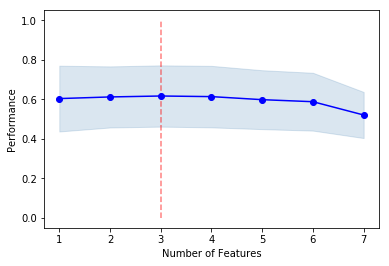

In [11]:
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.vlines(best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)


plt.show()